# Getting data into CAQL

CAQL offers the following ways to feed data into a query:


1. The metric functions: `metric:<kind>(<uuid>,<name>)`
2. The search functions: `search:metric:<kind>(<query>)`
3. The metriccluster function: `metriccluster(<id>)`
4. The find functions: `find:<kind>(<name glob>, <tag search>)`

## API Helper

We make use of the Python Data Fetching API for illustration purposes.

* Code: github.com/circonus-labs/python-circonusapi
* Blog: https://www.circonus.com/2018/05/less-toil-more-coil-telemetry-analysis-with-python/

Using the API is not covered in this tutorial.
Everything we do here can be done with the UI as well.

In [2]:
%run preamble.py
%matplotlib inline

## The metric:* package

The `metric:<kind>(<uuid>, <name>)` set of functions is the most fundamental way to get data into CAQL.

When debugging things, this should be the baseline to turn to if you want to know if a metric contains data or not, or how it looks like.

In Circonus metrics are uniquely identified by check UUID and metric name. The check UUID can be found on the checks page (or the metrics page). The metric name is listed there as well.

**TODO:** Make the UUID easier to find in the UI.

The kind parameter specifies, the rollup function that should be used for the input data.
Appart from the abundant "average" function, there is also:

* count -- how many samples arrived in that interval (can be used to derive sum)
* counter -- like a derivative but ignoring "counter" resets (used for CPU utilization, etc)

cf. https://login.circonus.com/resources/docs/user/Data.html#DataTypes

Most of the time you want to use the `metric:average`.

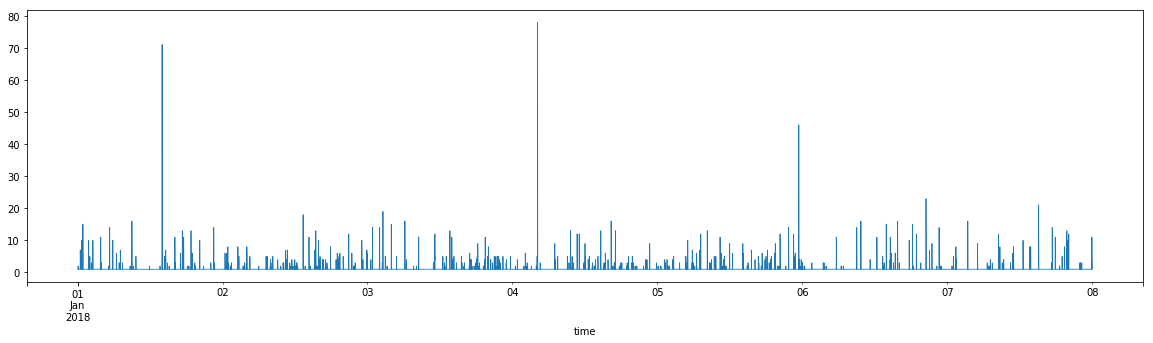

In [3]:
# Metric https://demo.circonus.com/checks/metrics/154743/duration
caql_plot('demo','''

metric:average("673044d5-379a-4037-89e5-c0694ef756ed","duration")

''', datetime(2018,1,1), 60, 60*24*7);

## The search:* package

The search:* function allows you to realize the following work flow:

1. Search for metrics on the metrics page: https://demo.circonus.com/checks/metrics
2. Pull data into CAQL by copy pasting the query.

**CAVEAT:** Currently no meta-data is attached to CAQL outputs. Hence metric names and UUIDs are not attached to the outputs. It's just: `output[1],...,output[N]`.

**TODO:** Attach meta-data to CAQL output streams, and allow naming of CAQL metrics.

### Example: Pull all duration metrics

(0, 50)

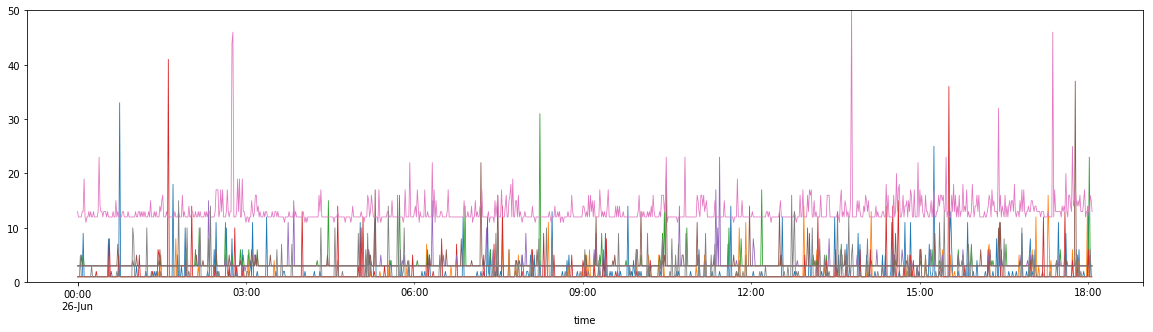

In [18]:
# 1. Pull all duration metrics https://demo.circonus.com/checks/metrics?search=duration
# 2. Plot:
caql_plot('demo','''

search:metric:average( p"duration%20(host%3Axkcd.com)" )

''', datetime(2018,6,26), 60, 60*24).set_ylim(0,50)

### Example: Refine search using the query builder

* Specify `(metric_name:...)` to avoid fuzzy matching
* Specify `(host: ...)` to limit search to checks against xkcd.com

* **HINT:** Using `(tag:<key>:<value>)` is a very common filter operation.
* **HINT:** You can use `(check_id:...)` to select a check instead of a UUID.

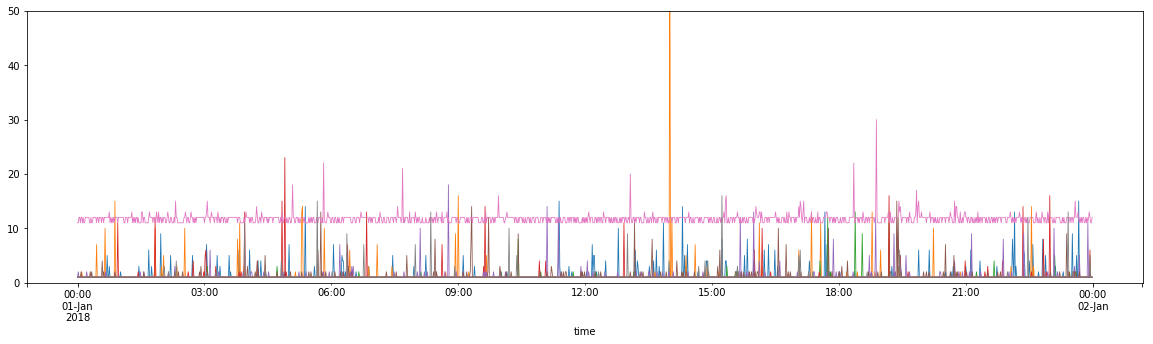

In [101]:
caql_plot("demo",'''

search:metric:average("(metric_name:duration) (host:xkcd.com)")

''', datetime(2018,1,1), 60, 60*24).set_ylim(0,50);

**HINT:** For search queries that involve special characters (in paricular quotes), you can use percent encoding to convert them into CAQL string literals:

```
p'This%20is%20a%20percent encoded string!'
```

Most browsers will show the percent-encoded search query in query string of the metrics page.

**HINT:** If you want to know how many metrics were returned by a search, you can use the `count()` function.

In [103]:
circ = circonusdata.CirconusData(config["demo"])
circ.caql('''search:metric:average("(metric_name:duration) (host:xkcd.com)") | count()''', 
          datetime(2018,1,1), 60, 5)['output[0]'][0]

8

## Metricclusters

Metricclusters are stored searches, e.g. https://demo.circonus.com/checks/clusters/1295506

They can be queried by ID.
    


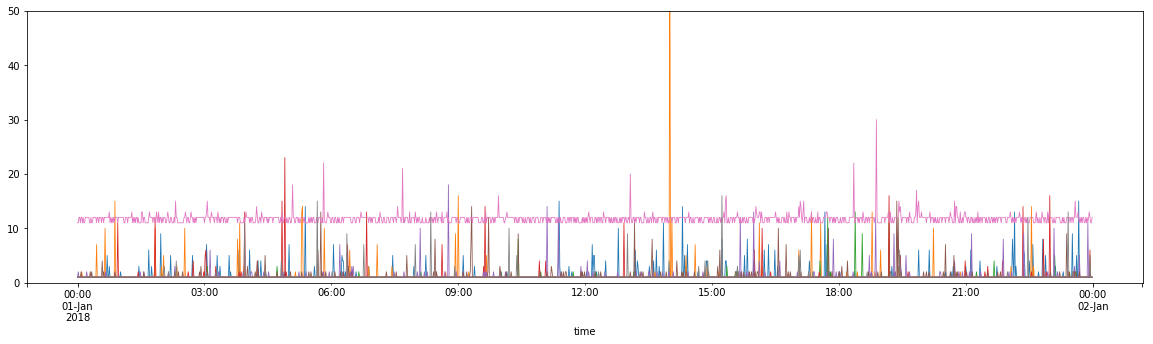

In [102]:
caql_plot("demo", '''

metriccluster(1295506)

''', datetime(2018,1,1), 60, 60*24).set_ylim(0,50);

## Tag search with find()

Stream tags are a recent addition to Circonus that allow you to submit tags along with metric data.

- FAST. Tag search is evaluated inside IRONdb, and does not require extra network roundtrips.
- Extends Graphite's glob search syntax
- Has regular expression searches built in

In the future this will become the main API for querying data in Circonus and IRONdb.

Some documentation: https://github.com/circonus-labs/reconnoiter/blob/master/src/noit_metric_tag_search.h#L34-L62

- **CAVEAT**: This feature is still not fully documented, and rolled out. 
- **CAVEAT**: Native Circonus tags are not automatically available as stream tags.
- **CAVEAT**: find() is not supported in CAQL checks at this point in time.
- **CAVEAT**: Metric names are currently prefixed by `reconnoiter.<check_name>.` (this will go away soon)
- **CAVEAT**: The API seems to have probelms with processing find() queries ATM.


Example Graph:

https://demo.circonus.com/trending/graphs/edit/ccdd9a11-62c3-43b3-8e57-f2c161803d85


In [78]:
# caql_plot('''
#
#   find("*duration")
#
#''', datetime(2018,1,1), 60, 60*24);